In [1]:
import numpy as np
from utils import *
import csv
import keras.utils
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import save_model,load_model,Model
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from tensorflow.keras.layers import Conv2D, UpSampling2D, AveragePooling2D, MaxPooling2D, Dense,Input, Dropout
from tensorflow.keras.layers import LeakyReLU,Reshape,BatchNormalization, Flatten
from tensorflow.keras.models import save_model
from tempfile import TemporaryFile
import tensorflow as tf
import pickle
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython import display
import time
from sklearn.mixture import GaussianMixture
import umap
from copy import deepcopy
from PIL import Image
from sklearn.cluster import KMeans
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD
from array import array 
import json


import os
cwd = os.getcwd()

from scipy.io import loadmat
from PIL import Image
from skimage.transform import rescale, resize
from skimage.color import rgb2gray
from sklearn.metrics import pairwise_distances_argmin_min

Using TensorFlow backend.


In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# from keras import backend as K
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# K.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# ! pip install --user umap-learn
# ##! pip uninstall --user keras
# ! pip install --user keras==2.1.6
# ! pip install --user matplotlib
# ! pip install --user np_utils
# ! pip install --user  Pillow

In [5]:
import os
cwd = os.getcwd()

In [6]:
zdim=10 # This is the dimension of intermediate latent variable 
epochs = 6000
epochstep = epochs/100
nofclasses=10
batchsize=200 
nofprojections = 100

## Data Generation

In [7]:
def getData(nMNIST,nUSPS,nSVHN):
    
    
    #Read MNIST

    (x_train,y_train),(x_test,y_test)=mnist.load_data()
    dataX_train=np.expand_dims(x_train.astype('float32')/255.,3)
    dataX_test=np.expand_dims(x_test.astype('float32')/255.,3)

    labelX_train = keras.utils.to_categorical(y_train, nofclasses)
    labelX_test = keras.utils.to_categorical(y_test, nofclasses)


    numdataTrain = labelX_train.shape[0]
    numdataTest = labelX_test.shape[0]

    dataX_train1 = np.reshape(dataX_train,[numdataTrain,28*28]) 
    dataX_test1 = np.reshape(dataX_test,[numdataTest,28*28]) 


    USPSMat  = []
    USPSTar  = []
    curPath  = r'/nas/home/USPSDataset/Numerals'
    savedImg = []

    for j in range(0,10):
        curFolderPath = curPath + '/' + str(j) 
        imgs =  os.listdir(curFolderPath)
        for img in imgs:
            curImg = curFolderPath + '/' + img
            if curImg[-3:] == 'png':
                img = Image.open(curImg,'r')
                img = img.resize((28, 28))
                savedImg = img
                tempim = np.array(img.getdata())
                tempim = np.reshape(tempim,[28,28])
                imgdata = ((255-tempim).astype(float))/255
                USPSMat.append(imgdata)
                USPSTar.append(j)


    dataY_train1 = np.array(USPSMat)
    USPSTar = np.array(USPSTar)
    labelY_train = keras.utils.to_categorical(USPSTar, nofclasses)

    dataY_train = np.zeros([len(USPSMat),28,28,1])
    for i in range(len(USPSMat)):
        dataY_train[i,:,:,0] = USPSMat[i]   


    USPSMattest  = []
    USPSTartest  = []
    curPathtest  = r'/nas/home/USPSDataset/Test'
    savedImgtest = []

    curFolderPathtest = curPathtest 
    imgs =  os.listdir(curFolderPathtest)
    for img in imgs:
        curImg = curFolderPathtest+'/'+img 
        if curImg[-3:] == 'png':
            imgt = Image.open(curImg,'r')
            imgt = imgt.resize((28, 28))
            savedImg = imgt
            lab =9- int(int(img[-8:-4])/150)        
            tempim = np.array(imgt.getdata())
            tempim = np.reshape(tempim,[28,28])
            imgdata = ((255-tempim).astype(float))/255        
            USPSMattest.append(imgdata)
            USPSTartest.append(lab)


    dataY_test1 = np.array(USPSMattest)
    USPSTartest = np.array(USPSTartest)
    labelY_test = keras.utils.to_categorical(USPSTartest, nofclasses)


    dataY_test = np.zeros([len(USPSMattest),28,28,1])
    for i in range(len(USPSMattest)):
        dataY_test[i,:,:,0] = USPSMattest[i]


    USPSMat  = []
    USPSTar  = []
    curPath  = r'/nas/home/SVHNdataset/'
    savedImg = []

    train = loadmat(curPath+'train_32x32.mat')
    test = loadmat(curPath+'test_32x32.mat')

    # train and test are python dictionaries
    # keys are ['__header__', '__version__', '__globals__', 'X', 'y']

    zX_train = train['X']
    zy_train = train['y']
    zX_test = test['X']
    zy_test = test['y']

    zX_train = np.rollaxis(zX_train, 3)
    zX_test = np.rollaxis(zX_test, 3)


    zy_train1 = zy_train
    zy_test1 = zy_test
    zy_train = np.zeros(zy_train1.shape[0])
    zy_test = np.zeros(zy_test.shape[0])

    for i in range(zy_test.shape[0]):
        zy_test[i] = zy_test1[i][0]
        if zy_test[i]==10:
            zy_test[i] = 0

    for i in range(zy_train.shape[0]):
        zy_train[i] = zy_train1[i][0]
        if zy_train[i]==10:
            zy_train[i] = 0

    labelZ_train = keras.utils.to_categorical(zy_train, nofclasses)
    labelZ_test = keras.utils.to_categorical(zy_test, nofclasses)

    dataZ_train = np.zeros([zy_train1.shape[0],28,28,1])
    dataZ_test = np.zeros([zy_test1.shape[0],28,28,1])


    for i in range(zX_train.shape[0]):
        dataZ_train[i,:,:,0] =  resize(rgb2gray(zX_train[i,:,:,0]),[28,28])

    for i in range(zX_test.shape[0]):
        dataZ_test[i,:,:,0] =  resize(rgb2gray(zX_test[i,:,:,0]),[28,28])


    task1 = nMNIST
    task2 = nUSPS
    task3 = nSVHN
 
    DATAX_train = {}
    DATAY_train = {}
    DATAX_test = {}
    DATAY_test = {}
    # MNIST
    DATAX_train[task1] = dataX_train
    DATAY_train[task1] = labelX_train
    DATAX_test[task1] = dataX_test
    DATAY_test[task1] = labelX_test
    # USPS
    DATAX_train[task2] = dataY_train
    DATAY_train[task2] = labelY_train
    DATAX_test[task2] = dataY_test
    DATAY_test[task2] = labelY_test
    # SVHN
    DATAX_train[task3] = dataZ_train
    DATAY_train[task3] = labelZ_train
    DATAX_test[task3] = dataZ_test
    DATAY_test[task3] = labelZ_test
    
    return DATAX_train, DATAY_train, DATAX_test, DATAY_test

###  X is input and Z the embedding space

In [8]:
imgX = Input(shape=(28, 28, 1), name="input_img")  # adapt this if using `channels_first` image data format
labelX=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot

In [9]:
# classifier = load_model(filepath='classifierEXT.h5')
# encoderX = load_model(filepath='encoderXEXT.h5')

## Encoder, Decoder and Classifier NN

In [10]:
def ClassifierNN(imgX,nofclasses):
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(imgX)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='block3_pool')(x)
    '''
    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='block4_pool')(x)
    # Block 5
    x = Conv2D(512, (2, 2), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (2, 2), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (2, 2), activation='relu', padding='valid', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    '''
    # Top layers
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)




    embed = Dense(nofclasses, activation='relu')(x)
    encoderX = Model(imgX, embed)

    return encoderX

    



In [11]:
def    classifierNN(nofclasses):
    yin =  Input(shape=( nofclasses,) )

    probX = Dense(nofclasses, activation='softmax')(yin)


    classifier=Model(inputs=[yin],outputs=[probX])
    return classifier


In [12]:
def myGMMfit(encoderX,classifier,dataX_train,labelX_train,nofclasses):
    gmmX = encoderX.predict(dataX_train)
    gmmY = np.argmax(labelX_train,axis=1)


    yper = classifier.predict(encoderX.predict(dataX_train))
    yper = np.argmax(yper, axis=1)


    gmmX = gmmX[gmmY==yper,:]
    gmmY = gmmY[gmmY==yper]

    gmmModel =  GaussianMixture(n_components=nofclasses,covariance_type='full', max_iter=300,init_params='kmeans', tol=1e-04) 


    gmmModel.fit(gmmX,gmmY)

    gmmModelSingle =  GaussianMixture(n_components=1,covariance_type='full') 

    for i in range(nofclasses):
        a= gmmX[gmmY==i,:]
        gmmModelSingle.fit(a)
        gmmModel.weights_[i] = .1 #gmmY[gmmY==i].shape[0]/gmmY.shape[0]
        gmmModel.covariances_[i] = gmmModelSingle.covariances_[0]
        gmmModel.means_[i] = gmmModelSingle.means_[0]

        gmmModel.precisions_cholesky_[i] = gmmModelSingle.precisions_cholesky_[0]
        gmmModel.precisions_[i] = gmmModelSingle.precisions_[0]


    return gmmModel



In [13]:
def buffSelection(encoderX,gmmModel,dataX_train,labelX_train,sizeperCl):
    
    gmmX = encoderX.predict(dataX_train)
    gmmY = np.argmax(labelX_train,axis=1)

    for i in range(nofclasses):
        
        ind = np.where(np.argmax(labelX_train,axis=1)==i)[0] 
        tempdataembed = gmmX[ind,:]
        tempData = dataX_train[ind,:]
        probabs = np.max(gmmModel.predict_proba(tempdataembed),axis=1) 
        if i == 0:
            buffData = tempData[probabs.argsort()[-sizeperCl:][::-1],:] 
            buffLab = i*np.ones([sizeperCl,1])
        else:
            buffData = np.concatenate([buffData,tempData[probabs.argsort()[-sizeperCl:][::-1],:]],axis=0)
            buffLab = np.concatenate([buffLab,i*np.ones([sizeperCl,1])])
    buffLab = keras.utils.to_categorical(buffLab, labelX_train.shape[1])
    return buffData, buffLab   

In [14]:
def Learnseq(nMNIST,nUSPS,nSVHN):
    
    DATAX_train, DATAY_train, DATAX_test, DATAY_test = getData(nMNIST,nUSPS,nSVHN)
    sizeperCl = 10
    nofclasses = 10
    Results1 = []
    Results2 = []
    Results3 = []
    epochs = 6000
    epochstep = epochs/100
    for ntask in range(3):

        if ntask == 0:
            dataX_train = DATAX_train[ntask]
            labelX_train = DATAY_train[ntask]
            dataX_test = DATAX_test[ntask]
            labelX_test = DATAY_test[ntask]


            classifier = classifierNN(nofclasses)
            encoderX = ClassifierNN(imgX,nofclasses)

            discriminationLoss=K.mean(K.categorical_crossentropy(labelX,classifier(encoderX(imgX)))) 
            params=encoderX.weights  + classifier.weights  
            myLoss = discriminationLoss
            opt = Adam(lr=1e-4) # very important
            updates = opt.get_updates(myLoss,params)
            train = K.function(inputs=[imgX,labelX],outputs=[discriminationLoss],updates=updates)

            loss = []
            fig,ax=plt.subplots(1,figsize=(10,10))

            for itr in range(epochs):

                indTrainDataX,trainLabelX=batchGenerator(labelX_train,batchsize,nofclasses=10)
                trainDataX=dataX_train[indTrainDataX,...]
                loss.append(train(inputs=[trainDataX, trainLabelX ]))


                if itr%epochstep==0:
                    perd_label_X = classifier.predict(encoderX.predict(DATAX_test[0]))
                    perd_label_Y = classifier.predict(encoderX.predict(DATAX_test[1]))
                    perd_label_Z = classifier.predict(encoderX.predict(DATAX_test[2]))
                    Results1.append(100*float(sum(1*(np.argmax(perd_label_X,axis=1)==np.argmax(np.squeeze(DATAY_test[0]),axis=1))))/DATAX_test[0].shape[0])
                    Results2.append(100*float(sum(1*(np.argmax(perd_label_Y,axis=1)==np.argmax(np.squeeze(DATAY_test[1]),axis=1))))/DATAX_test[1].shape[0])
                    Results3.append(100*float(sum(1*(np.argmax(perd_label_Z,axis=1)==np.argmax(np.squeeze(DATAY_test[2]),axis=1))))/DATAX_test[2].shape[0])


            # GMM fiting and buffer      
            gmmModel = myGMMfit(encoderX,classifier,dataX_train,labelX_train,nofclasses)
            buffData, buffLab   = buffSelection(encoderX,gmmModel,dataX_train,labelX_train,sizeperCl)


        else:

            dataY_train = DATAX_train[ntask]
            labelY_train = DATAY_train[ntask]
            dataY_test = DATAX_test[ntask]
            labelY_test = DATAY_test[ntask]

            imgY = Input(shape=(nofclasses,) )  # adapt this if using `channels_first` image data format
            labelY=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot
            lamda2=1e-2
            theta=tf.keras.backend.placeholder(shape = (nofprojections, nofclasses), dtype='float32')
            labelW =  K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot
            imgW = Input(shape=(28, 28, 1) )  

            discriminationLoss= K.mean(K.categorical_crossentropy(labelY,classifier(imgY)))   \
                                + K.mean(K.categorical_crossentropy(labelW,classifier(encoderX(imgW))))   
            matchingLoss=sWasserstein(encoderX(imgX),imgY,theta,nclass=nofclasses,Cp=None,Cq=None,)+\
                            sWasserstein(encoderX(imgX),encoderX(imgW),theta,nclass=nofclasses,Cp=None,Cq=None,)+\
                            sWasserstein(encoderX(imgW),imgY,theta,nclass=nofclasses,Cp=None,Cq=None,)
            myLoss=  lamda2*matchingLoss  + discriminationLoss  
            params=encoderX.weights  + classifier.weights  
            opt = Adam(lr=1e-4) # very important
            updates = opt.get_updates(myLoss,params)
            train = K.function(inputs=[imgX,imgY,labelY,theta,imgW, labelW],outputs=[lamda2*matchingLoss],updates=updates)



            thres = .9
            fig,ax=plt.subplots(1,figsize=(10,10))
            epochs2 = 50 * 100
            epochstep = epochs2/100

            for itr in range(epochs2):
                indTrainDataY,trainLabelY=batchGenerator(labelY_train,batchsize,nofclasses=10)
                trainDataY=dataY_train[indTrainDataY,...]

                indTrainDataX,trainLabelX=batchGenerator(buffLab,batchsize,nofclasses=nofclasses)
                trainDataX=buffData[indTrainDataX,...]    

                Yembed,Yembedlabel1  = gmmModel.sample(n_samples=20*batchsize)
                Yembedlabel = keras.utils.to_categorical(Yembedlabel1)   


                theta_=generateTheta(nofprojections,nofclasses)
                loss.append(train(inputs=[trainDataY,Yembed,Yembedlabel,theta_ ,trainDataX, trainLabelX ]))



                if itr%epochstep==0:
                    perd_label_X = classifier.predict(encoderX.predict(DATAX_test[0]))
                    perd_label_Y = classifier.predict(encoderX.predict(DATAX_test[1]))
                    perd_label_Z = classifier.predict(encoderX.predict(DATAX_test[2]))
                    Results1.append(100*float(sum(1*(np.argmax(perd_label_X,axis=1)==np.argmax(np.squeeze(DATAY_test[0]),axis=1))))/DATAY_test[0].shape[0])
                    Results2.append(100*float(sum(1*(np.argmax(perd_label_Y,axis=1)==np.argmax(np.squeeze(DATAY_test[1]),axis=1))))/DATAY_test[1].shape[0])
                    Results3.append(100*float(sum(1*(np.argmax(perd_label_Z,axis=1)==np.argmax(np.squeeze(DATAY_test[2]),axis=1))))/DATAY_test[2].shape[0])



            if ntask == 2:
                break


            # GMM fiting and buffer  

    #         dataX_temp =  np.concatenate([buffData,dataY_train],axis=0)
    #         labelX_temp = np.concatenate([buffLab,labelY_train],axis=0)
            gmmModel = myGMMfit(encoderX,classifier,dataY_train,labelY_train,nofclasses)
            buffDatatemp, buffLabtemp   = buffSelection(encoderX,gmmModel,dataY_train,labelY_train,sizeperCl)

            buffData = np.concatenate([buffData,buffDatatemp],axis=0)
            buffLab = np.concatenate([buffLab,buffLabtemp],axis=0)

    return Results1, Results2, Results3

/nas/home/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/nas/home/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:128: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


/nas/home/.local/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/nas/home/.local/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/nas/home/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/nas/home/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykern

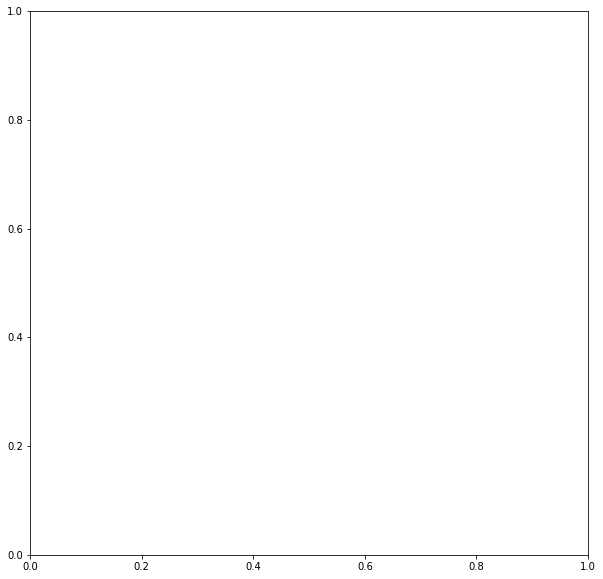

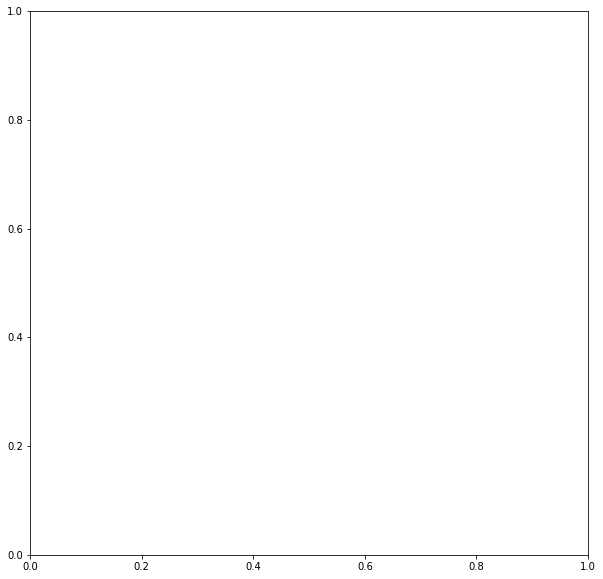

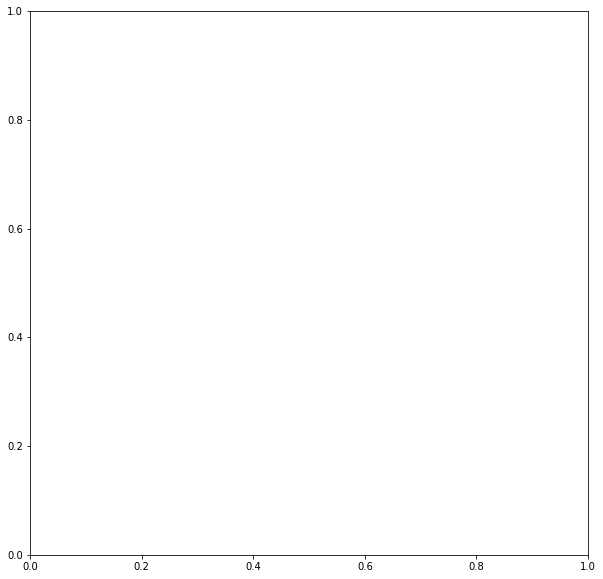

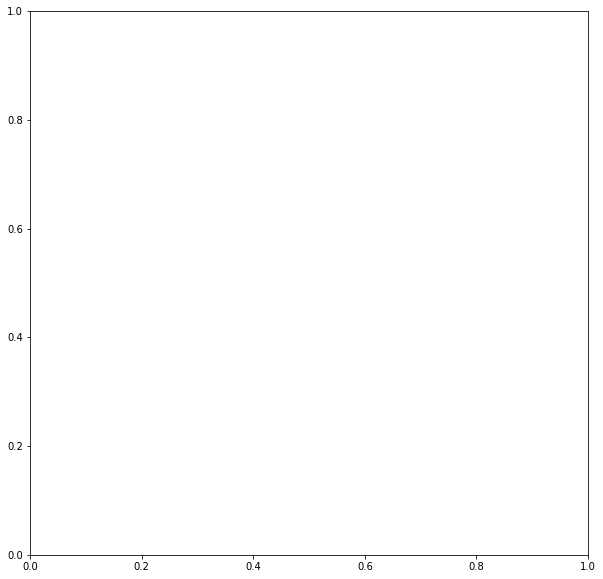

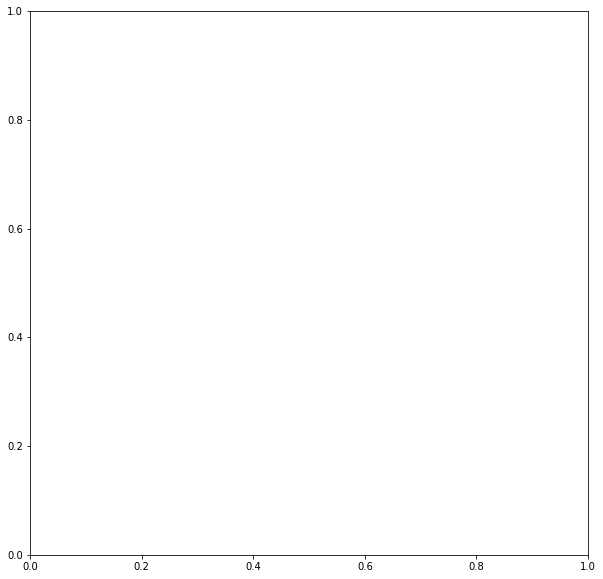

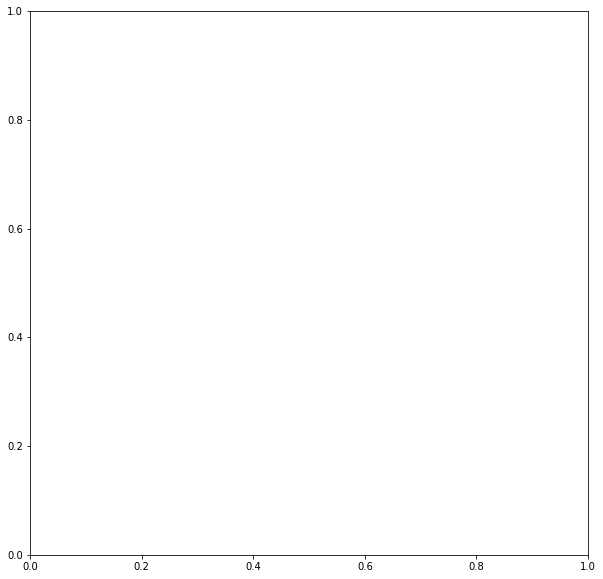

In [15]:
nMNIST = 2
nUSPS = 1
nSVHN = 0

Results1, Results2, Results3 = Learnseq(nMNIST,nUSPS,nSVHN)

nMNIST = 1
nUSPS = 2
nSVHN = 0

Results11, Results21, Results31 = Learnseq(nMNIST,nUSPS,nSVHN)


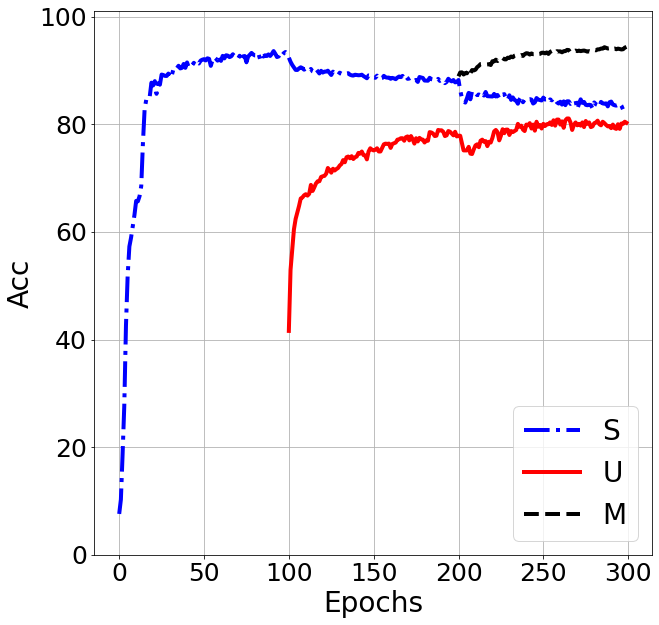

In [16]:
fig,ax=plt.subplots(1,figsize=(10,10))


plt.plot(Results1, '-.b', linewidth=4.0, label='S')

plt.plot(list(range(100,300)),Results2[100:], 'r', linewidth=4.0, label='U')

plt.plot(list(range(200,300)),Results3[200:], '--k', linewidth=4.0, label='M')




plt.legend(loc='lower right', fontsize=28)

plt.xlabel('Epochs', fontsize=28)
plt.ylabel('Acc', fontsize=28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim([0,101])
plt.grid()
plt.show()


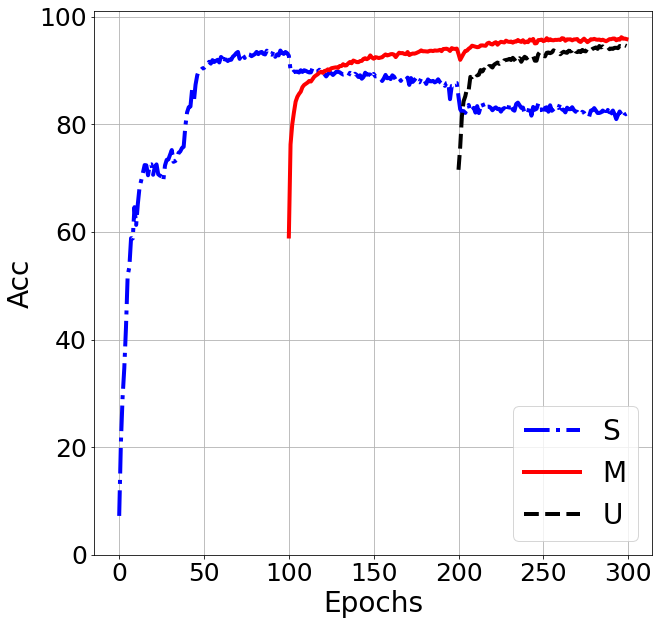

In [17]:
fig,ax=plt.subplots(1,figsize=(10,10))


plt.plot(Results11, '-.b', linewidth=4.0, label='S')

plt.plot(list(range(100,300)),Results21[100:], 'r', linewidth=4.0, label='M')

plt.plot(list(range(200,300)),Results31[200:], '--k', linewidth=4.0, label='U')




plt.legend(loc='lower right', fontsize=28)

plt.xlabel('Epochs', fontsize=28)
plt.ylabel('Acc', fontsize=28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim([0,101])
plt.grid()
plt.show()
